# RAISE-26: Daily Life vs Grand Narratives

End-to-end, one-click pipeline to compare micro vs macro framings of AI in news headlines and persona-based LLM outputs.

## Setup & configuration

Configure dataset selection and import standard libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

sns.set_theme(style="whitegrid")

USE_DATASET = "A"  # "A" or "B"

DATA_DIR = Path("data")
NEWS_FILES = {
    "A": "dataset_A_news_full_10500.csv",
    "B": "dataset_B_news_subset_3500.csv",
}

DATASET_C_CANDIDATES = [
    "Dataset_C_prompts_&_queries.csv",
    "Dataset_C_prompts_-_queries.csv",
]


def resolve_news_path(use_dataset: str) -> Path:
    if use_dataset not in NEWS_FILES:
        raise ValueError(f"USE_DATASET must be one of {list(NEWS_FILES.keys())}")
    path = DATA_DIR / NEWS_FILES[use_dataset]
    if not path.exists():
        raise FileNotFoundError(f"News dataset not found: {path}")
    return path


def resolve_dataset_c_path() -> Path:
    for name in DATASET_C_CANDIDATES:
        path = DATA_DIR / name
        if path.exists():
            return path
    raise FileNotFoundError(f"Dataset C not found in {DATA_DIR} with candidates {DATASET_C_CANDIDATES}")


NEWS_PATH = resolve_news_path(USE_DATASET)
DATASET_C_PATH = resolve_dataset_c_path()

print(f"News dataset path: {NEWS_PATH}")
print(f"Dataset C path: {DATASET_C_PATH}")

News dataset path: data\dataset_A_news_full_10500.csv
Dataset C path: data\Dataset_C_prompts_&_queries.csv


## Load and inspect datasets

Read CSVs from `data/`, normalize column names, and compute basic time fields.

In [4]:
def normalize_colname(col: str) -> str:
    col = col.strip().lower()
    col = re.sub(r"[\s\-]+", "_", col)
    col = re.sub(r"[^a-z0-9_]+", "", col)
    return col


def find_column(norm_map: dict, candidates: set) -> str | None:
    for original, normed in norm_map.items():
        if normed in candidates:
            return original
    return None


def load_news(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    norm_map = {col: normalize_colname(col) for col in df.columns}

    title_col = find_column(norm_map, {"title", "headline", "news_title"})
    source_col = find_column(norm_map, {"source", "publisher", "media_source", "outlet"})
    date_col = find_column(norm_map, {"date", "published", "publish_date", "datetime", "timestamp"})
    classes_col = find_column(
        norm_map,
        {"classesstr", "classes_str", "classes", "class", "labels", "categories", "category"},
    )
    id_col = find_column(norm_map, {"headline_id", "news_id", "article_id", "doc_id", "id"})

    missing = [
        name
        for name, col in [
            ("title", title_col),
            ("source", source_col),
            ("date", date_col),
            ("classesstr", classes_col),
        ]
        if col is None
    ]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Available columns: {list(df.columns)}")

    rename_map = {
        title_col: "title",
        source_col: "source",
        date_col: "date",
        classes_col: "classesstr",
    }
    if id_col is not None:
        rename_map[id_col] = "headline_id"

    df = df.rename(columns=rename_map)

    if "headline_id" not in df.columns:
        df["headline_id"] = np.arange(len(df))

    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["quarter"] = df["date"].dt.quarter
    df["dayofweek"] = df["date"].dt.dayofweek
    df["isweekend"] = df["dayofweek"] >= 5

    df["title"] = df["title"].astype(str)
    df["source"] = df["source"].astype(str)
    df["classesstr"] = df["classesstr"].fillna("").astype(str)

    return df


def load_dataset_c(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    norm_map = {col: normalize_colname(col) for col in df.columns}

    prompt_col = find_column(norm_map, {"prompt", "instruction", "persona_prompt"})
    query_col = find_column(norm_map, {"query", "question"})
    llm_col = find_column(norm_map, {"llm", "model", "model_name"})
    output_col = find_column(
        norm_map,
        {"llmoutput", "llm_output", "output", "response", "completion"},
    )

    missing = [
        name
        for name, col in [
            ("Prompt", prompt_col),
            ("Query", query_col),
            ("LLM", llm_col),
            ("LLMoutput", output_col),
        ]
        if col is None
    ]
    if missing:
        raise ValueError(f"Missing required columns in Dataset C: {missing}. Available columns: {list(df.columns)}")

    df = df.rename(
        columns={
            prompt_col: "Prompt",
            query_col: "Query",
            llm_col: "LLM",
            output_col: "LLMoutput",
        }
    )
    return df


news_df = load_news(NEWS_PATH)
persona_df = load_dataset_c(DATASET_C_PATH)

news_df.head()

,title,link,date,source,number_of_characters_title,number_of_words_title,day_of_week,month,year,quarter,is_weekend,classesstr,headline_id,dayofweek,isweekend
0,Google’s AI is the ‘worst’ for stealing conten...,https://news.google.com/rss/articles/CBMipgFBV...,2025-09-11,Fortune,74,13,Thursday,9,2025,3,False,Sentiment (Positive / Negative Feelings); Huma...,0,3,False
1,Powering the Next Wave of Enterprise Innovatio...,https://news.google.com/rss/articles/CBMitgFBV...,2025-09-11,Silicon Canals,106,16,Thursday,9,2025,3,False,"Creativity, Expression & Identity; Work, Jobs ...",1,3,False
2,AI a ‘strategic necessity’ law lecturer says,https://news.google.com/rss/articles/CBMiiAFBV...,2025-09-11,qlsproctor.com.au,64,9,Thursday,9,2025,3,False,"Society, Ethics & Culture",2,3,False
3,Datacom sees AI agents as pivotal to legacy ap...,https://news.google.com/rss/articles/CBMirAFBV...,2025-09-11,ARNnet,70,12,Thursday,9,2025,3,False,"Routine, Lifestyle & Behavior",3,3,False
4,"Student Blog: Startups, AI, and Lessons from S...",https://news.google.com/rss/articles/CBMijwFBV...,2025-09-11,The University of Queensland,85,13,Thursday,9,2025,3,False,"Learning, Knowledge & Education",4,3,False


In [5]:
print("News columns:", list(news_df.columns))
print("News rows:", len(news_df))
print("Persona columns:", list(persona_df.columns))
print("Persona rows:", len(persona_df))

persona_df.head()

News columns: ['title', 'link', 'date', 'source', 'number_of_characters_title', 'number_of_words_title', 'day_of_week', 'month', 'year', 'quarter', 'is_weekend', 'classesstr', 'headline_id', 'dayofweek', 'isweekend']
News rows: 10500
Persona columns: ['Prompt', 'Query', 'LLM', 'LLMoutput']
Persona rows: 8820


,Prompt,Query,LLM,LLMoutput
0,Role: Research Assistant\nTask: Answer questio...,In what ways has AI changed how you see yourself?,Mistral,"As a research assistant, AI has not significan..."
1,Role: Research Assistant\nTask: Answer questio...,Do you feel AI has influenced your personal id...,Mistral,"As a research assistant, I do not possess pers..."
2,Role: Research Assistant\nTask: Answer questio...,Has AI altered how you express yourself online...,Mistral,"As a research assistant, I do not have persona..."
3,Role: Research Assistant\nTask: Answer questio...,How accurately does AI mirror your preferences?,Mistral,"As a research assistant, I don't have personal..."
4,Role: Research Assistant\nTask: Answer questio...,How has AI affected your sense of independence?,Mistral,"As a research assistant, AI has not directly i..."


## Define micro vs macro taxonomy

Hard-code class sets and map class labels to micro/macro levels.

In [6]:
MACRO_CLASSES = {
    "Society, Ethics & Culture",
    "Work, Jobs & Economy",
    "Technology Interaction",
}

MICRO_CLASSES = {
    "Routine, Lifestyle & Behavior",
    "Emotion, Motivation & Well-being",
    "Health, Safety & Risk",
    "Learning, Knowledge & Education",
    "Social Interaction & Relationships",
    "Human Roles",
    "Cognitive Decision-Making",
    "Creativity, Expression Identity",
}


def map_class_to_level(cls_name: str) -> str:
    in_micro = cls_name in MICRO_CLASSES
    in_macro = cls_name in MACRO_CLASSES
    if in_micro and in_macro:
        return "both"
    if in_micro:
        return "micro"
    if in_macro:
        return "macro"
    return "unknown"


def explode_classes(df: pd.DataFrame) -> pd.DataFrame:
    exploded = df.copy()
    exploded["class_name"] = exploded["classesstr"].str.split(";")
    exploded = exploded.explode("class_name")
    exploded["class_name"] = exploded["class_name"].str.strip()
    exploded = exploded[exploded["class_name"] != ""]
    return exploded


news_exploded = explode_classes(news_df)
news_exploded["class_level"] = news_exploded["class_name"].apply(map_class_to_level)

unique_classes = sorted(news_exploded["class_name"].dropna().unique())
unknown_classes = [c for c in unique_classes if map_class_to_level(c) == "unknown"]

print(f"Unique classes: {len(unique_classes)}")
print(f"Unknown classes not in taxonomy: {unknown_classes}")

Unique classes: 12
Unknown classes not in taxonomy: ['Cognitive & Decision-Making', 'Creativity, Expression & Identity', 'Sentiment (Positive / Negative Feelings)', 'Technology & Interaction']


In [7]:
def summarize_headline_level(levels: pd.Series) -> str:
    has_micro = levels.isin(["micro", "both"]).any()
    has_macro = levels.isin(["macro", "both"]).any()
    if has_micro and has_macro:
        return "both"
    if has_micro:
        return "micro"
    if has_macro:
        return "macro"
    return "unknown"


headline_levels = (
    news_exploded.groupby("headline_id")["class_level"]
    .apply(summarize_headline_level)
    .reset_index()
    .rename(columns={"class_level": "level"})
)

news_headline = news_df.merge(headline_levels, on="headline_id", how="left")
news_headline["level"] = news_headline["level"].fillna("unknown")

news_headline[["headline_id", "title", "source", "level"]].head()

,headline_id,title,source,level
0,0,Google’s AI is the ‘worst’ for stealing conten...,Fortune,both
1,1,Powering the Next Wave of Enterprise Innovatio...,Silicon Canals,macro
2,2,AI a ‘strategic necessity’ law lecturer says,qlsproctor.com.au,macro
3,3,Datacom sees AI agents as pivotal to legacy ap...,ARNnet,micro
4,4,"Student Blog: Startups, AI, and Lessons from S...",The University of Queensland,micro


## Media side: analyze Dataset A/B

Compute distributions and basic time-series for micro vs macro levels.

In [8]:
def level_summary(df: pd.DataFrame, level_col: str = "level") -> pd.DataFrame:
    counts = df[level_col].value_counts(dropna=False).reindex(
        ["micro", "macro", "both", "unknown"], fill_value=0
    )
    pct = (counts / counts.sum() * 100).round(1)
    return pd.DataFrame({"count": counts, "pct": pct})


news_level_summary = level_summary(news_headline)
news_level_summary

,count,pct
level,,
micro,4516,43.0
macro,2413,23.0
both,1545,14.7
unknown,2026,19.3


C:\Users\saman\AppData\Local\Temp\ipykernel_34152\914240660.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


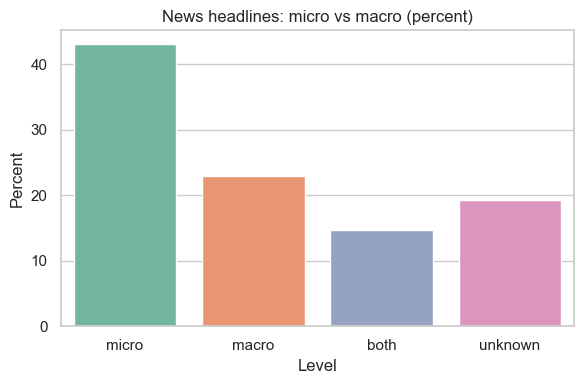

In [9]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    x=news_level_summary.index,
    y=news_level_summary["pct"],
    palette="Set2",
)
ax.set_title("News headlines: micro vs macro (percent)")
ax.set_ylabel("Percent")
ax.set_xlabel("Level")
plt.xticks(rotation=0)
plt.tight_layout()

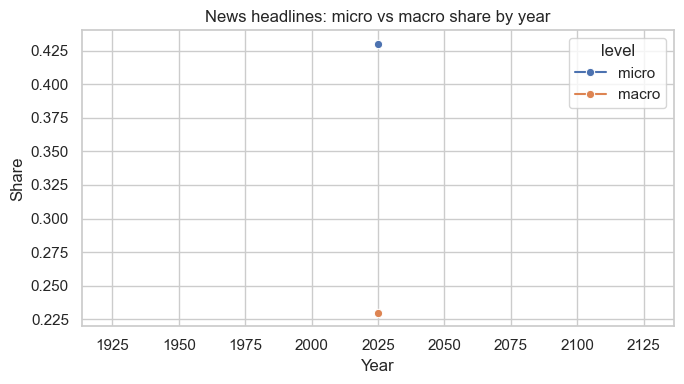

In [10]:
year_counts = (
    news_headline.dropna(subset=["year"])
    .groupby(["year", "level"])\
    .size()
    .unstack(fill_value=0)
)

year_share = year_counts.div(year_counts.sum(axis=1), axis=0).reset_index()

plt.figure(figsize=(7, 4))
plot_data = year_share.melt(id_vars="year", value_vars=["micro", "macro"])
ax = sns.lineplot(data=plot_data, x="year", y="value", hue="level", marker="o")
ax.set_title("News headlines: micro vs macro share by year")
ax.set_ylabel("Share")
ax.set_xlabel("Year")
plt.tight_layout()

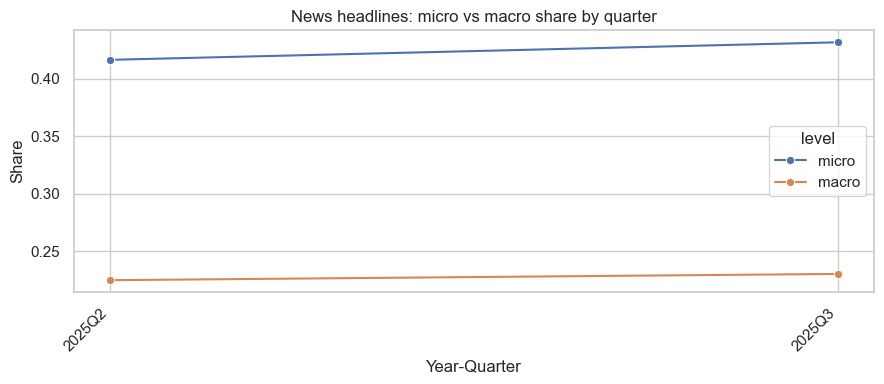

In [11]:
news_headline["year_quarter"] = news_headline["date"].dt.to_period("Q").astype(str)

quarter_counts = (
    news_headline.dropna(subset=["year_quarter"])
    .groupby(["year_quarter", "level"])
    .size()
    .unstack(fill_value=0)
)

quarter_share = quarter_counts.div(quarter_counts.sum(axis=1), axis=0).reset_index()

plt.figure(figsize=(9, 4))
plot_data = quarter_share.melt(id_vars="year_quarter", value_vars=["micro", "macro"])
ax = sns.lineplot(data=plot_data, x="year_quarter", y="value", hue="level", marker="o")
ax.set_title("News headlines: micro vs macro share by quarter")
ax.set_ylabel("Share")
ax.set_xlabel("Year-Quarter")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

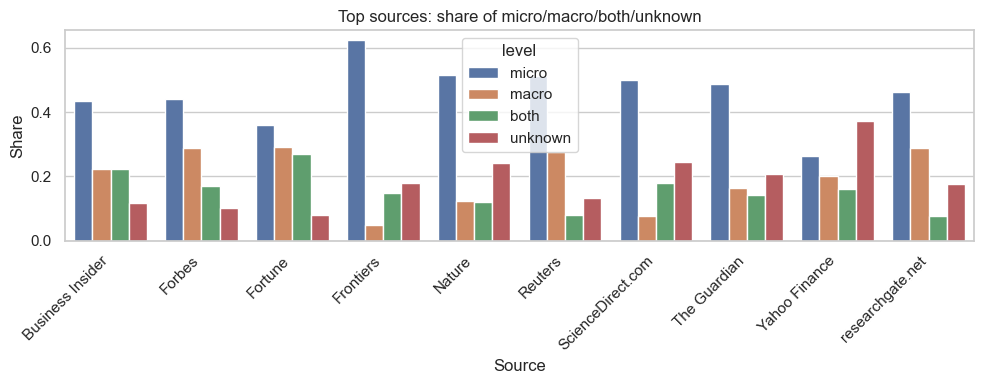

In [12]:
TOP_N_SOURCES = 10

source_counts = news_headline.groupby("source").size().sort_values(ascending=False)
top_sources = source_counts.head(TOP_N_SOURCES).index

source_level = (
    news_headline[news_headline["source"].isin(top_sources)]
    .groupby(["source", "level"])\
    .size()
    .unstack(fill_value=0)
)

source_share = source_level.div(source_level.sum(axis=1), axis=0).reset_index()
plot_data = source_share.melt(id_vars="source", value_vars=["micro", "macro", "both", "unknown"])

plt.figure(figsize=(10, 4))
ax = sns.barplot(data=plot_data, x="source", y="value", hue="level")
ax.set_title("Top sources: share of micro/macro/both/unknown")
ax.set_ylabel("Share")
ax.set_xlabel("Source")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

### Optional: top classes within micro vs macro

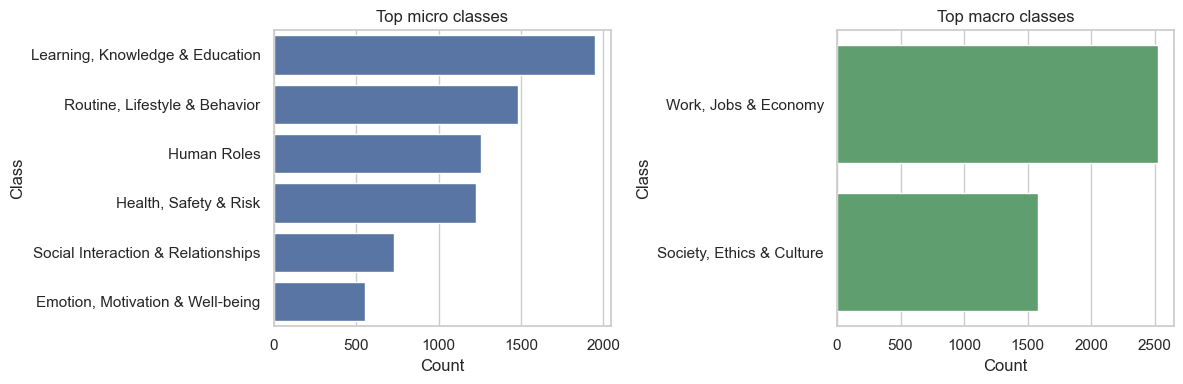

In [13]:
TOP_N_CLASSES = 10

micro_class_counts = (
    news_exploded[news_exploded["class_level"] == "micro"]["class_name"]
    .value_counts()
    .head(TOP_N_CLASSES)
)
macro_class_counts = (
    news_exploded[news_exploded["class_level"] == "macro"]["class_name"]
    .value_counts()
    .head(TOP_N_CLASSES)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

sns.barplot(x=micro_class_counts.values, y=micro_class_counts.index, ax=axes[0], color="#4C72B0")
axes[0].set_title("Top micro classes")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Class")

sns.barplot(x=macro_class_counts.values, y=macro_class_counts.index, ax=axes[1], color="#55A868")
axes[1].set_title("Top macro classes")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Class")

plt.tight_layout()

## Persona side: analyze Dataset C

Extract persona labels and tag outputs as micro/macro using keyword heuristics.

In [14]:
MICRO_KEYWORDS = [
    "daily", "day-to-day", "routine", "habit", "schedule", "morning",
    "sleep", "diet", "exercise", "productivity", "study", "homework",
    "class", "school", "university", "family", "friends", "relationship",
    "partner", "mental health", "stress", "anxiety", "motivation",
    "focus", "workday", "office", "coworkers", "social media", "apps",
]

MACRO_KEYWORDS = [
    "policy", "regulation", "regulatory", "government", "governance",
    "law", "legal", "democracy", "society", "societal", "economy",
    "economic", "labor market", "job market", "inequality", "rights",
    "privacy", "fairness", "bias", "security", "national security",
    "infrastructure", "big tech", "platforms", "industry-wide",
]


def extract_persona(prompt: str) -> str:
    if not isinstance(prompt, str) or not prompt.strip():
        return "Unknown"
    for pattern in [r"Role\s*[:\-]\s*(.+)", r"Persona\s*[:\-]\s*(.+)"]:
        match = re.search(pattern, prompt, flags=re.IGNORECASE)
        if match:
            value = match.group(1).strip().splitlines()[0].strip()
            return re.sub(r"[\s\|\-]+$", "", value)[:80]
    first_line = prompt.strip().splitlines()[0]
    first_line = re.sub(r"^\s*(You are|Youre|You are an?)\s+", "", first_line, flags=re.IGNORECASE)
    return first_line[:80]


def tag_llm_output_level(text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return "unknown"
    lower = text.lower()
    has_micro = any(k in lower for k in MICRO_KEYWORDS)
    has_macro = any(k in lower for k in MACRO_KEYWORDS)
    if has_micro and has_macro:
        return "both"
    if has_micro:
        return "micro"
    if has_macro:
        return "macro"
    return "unknown"


persona_df = persona_df.copy()
persona_df["persona"] = persona_df["Prompt"].apply(extract_persona)

combined_text = (
    persona_df["LLMoutput"].fillna("").astype(str)
    + " \n"
    + persona_df["Query"].fillna("").astype(str)
)

persona_df["level"] = combined_text.apply(tag_llm_output_level)

persona_df[["persona", "LLM", "level"]].head()

,persona,LLM,level
0,Research Assistant,Mistral,unknown
1,Research Assistant,Mistral,unknown
2,Research Assistant,Mistral,unknown
3,Research Assistant,Mistral,unknown
4,Research Assistant,Mistral,micro


In [15]:
persona_level_summary = level_summary(persona_df)
persona_level_summary

,count,pct
level,,
micro,2745,31.1
macro,1000,11.3
both,296,3.4
unknown,4779,54.2


C:\Users\saman\AppData\Local\Temp\ipykernel_34152\2894561403.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


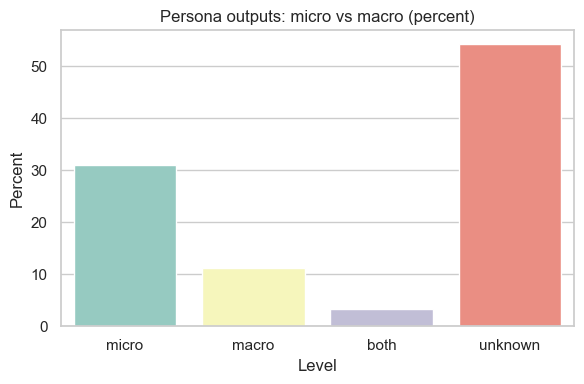

In [16]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    x=persona_level_summary.index,
    y=persona_level_summary["pct"],
    palette="Set3",
)
ax.set_title("Persona outputs: micro vs macro (percent)")
ax.set_ylabel("Percent")
ax.set_xlabel("Level")
plt.xticks(rotation=0)
plt.tight_layout()

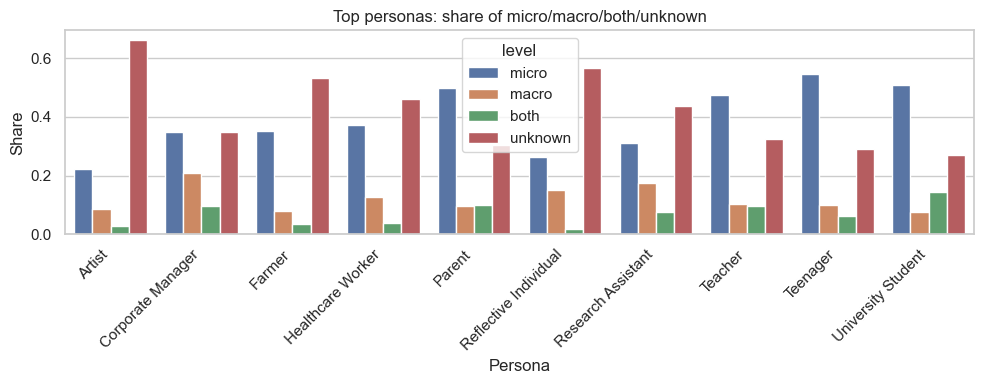

In [17]:
TOP_N_PERSONAS = 10

persona_counts = persona_df["persona"].value_counts().head(TOP_N_PERSONAS).index
persona_level = (
    persona_df[persona_df["persona"].isin(persona_counts)]
    .groupby(["persona", "level"])\
    .size()
    .unstack(fill_value=0)
)
persona_share = persona_level.div(persona_level.sum(axis=1), axis=0).reset_index()
plot_data = persona_share.melt(id_vars="persona", value_vars=["micro", "macro", "both", "unknown"])

plt.figure(figsize=(10, 4))
ax = sns.barplot(data=plot_data, x="persona", y="value", hue="level")
ax.set_title("Top personas: share of micro/macro/both/unknown")
ax.set_ylabel("Share")
ax.set_xlabel("Persona")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

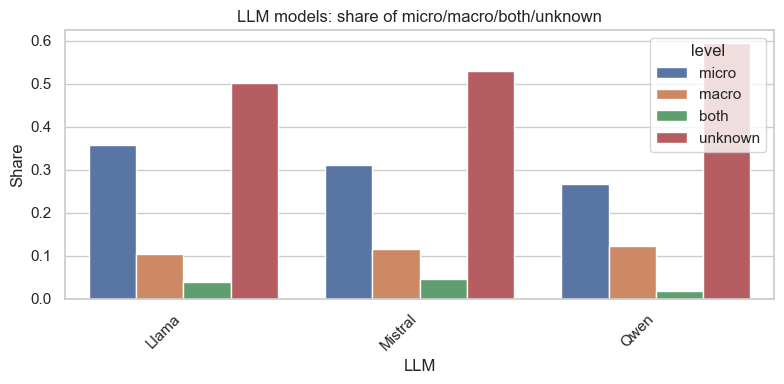

In [18]:
llm_level = persona_df.groupby(["LLM", "level"]).size().unstack(fill_value=0)
llm_share = llm_level.div(llm_level.sum(axis=1), axis=0).reset_index()
plot_data = llm_share.melt(id_vars="LLM", value_vars=["micro", "macro", "both", "unknown"])

plt.figure(figsize=(8, 4))
ax = sns.barplot(data=plot_data, x="LLM", y="value", hue="level")
ax.set_title("LLM models: share of micro/macro/both/unknown")
ax.set_ylabel("Share")
ax.set_xlabel("LLM")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

## Compare news vs personas

Side-by-side tables and charts for micro vs macro framing.

In [19]:
comparison_table = pd.DataFrame(
    {
        "micro": [news_level_summary.loc["micro", "pct"], persona_level_summary.loc["micro", "pct"]],
        "macro": [news_level_summary.loc["macro", "pct"], persona_level_summary.loc["macro", "pct"]],
        "both": [news_level_summary.loc["both", "pct"], persona_level_summary.loc["both", "pct"]],
        "unknown": [news_level_summary.loc["unknown", "pct"], persona_level_summary.loc["unknown", "pct"]],
    },
    index=["news", "personas"],
)

comparison_table

,micro,macro,both,unknown
news,43.0,23.0,14.7,19.3
personas,31.1,11.3,3.4,54.2


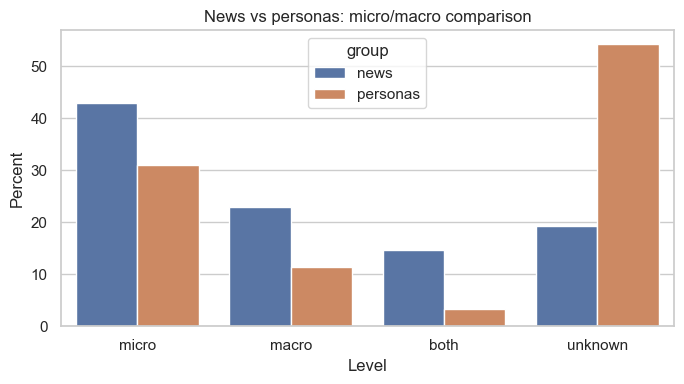

In [20]:
plot_data = comparison_table.reset_index().melt(id_vars="index")
plot_data = plot_data.rename(columns={"index": "group", "variable": "level", "value": "pct"})

plt.figure(figsize=(7, 4))
ax = sns.barplot(data=plot_data, x="level", y="pct", hue="group")
ax.set_title("News vs personas: micro/macro comparison")
ax.set_ylabel("Percent")
ax.set_xlabel("Level")
plt.tight_layout()

## Visualizations & summary tables

Compact tables for slide-ready reporting.

In [21]:
summary_tables = {
    "news_level_summary": news_level_summary,
    "persona_level_summary": persona_level_summary,
    "comparison_table_pct": comparison_table,
}

for name, table in summary_tables.items():
    print("\n", name)
    display(table)

# Slide-friendly tables
source_level_pct = source_share.set_index("source")[["micro", "macro", "both", "unknown"]]
persona_level_pct = persona_share.set_index("persona")[["micro", "macro", "both", "unknown"]]

print("\nTop sources (share):")
display(source_level_pct.head(10))

print("\nTop personas (share):")
display(persona_level_pct.head(10))


 news_level_summary


,count,pct
level,,
micro,4516,43.0
macro,2413,23.0
both,1545,14.7
unknown,2026,19.3



 persona_level_summary


,count,pct
level,,
micro,2745,31.1
macro,1000,11.3
both,296,3.4
unknown,4779,54.2



 comparison_table_pct


,micro,macro,both,unknown
news,43.0,23.0,14.7,19.3
personas,31.1,11.3,3.4,54.2



Top sources (share):


level,micro,macro,both,unknown
source,,,,
Business Insider,0.434211,0.223684,0.223684,0.118421
Forbes,0.442105,0.289474,0.168421,0.100000
Fortune,0.360000,0.290000,0.270000,0.080000
Frontiers,0.623457,0.049383,0.148148,0.179012
Nature,0.514403,0.123457,0.119342,0.242798
Reuters,0.513158,0.276316,0.078947,0.131579
ScienceDirect.com,0.500000,0.076923,0.179487,0.243590
The Guardian,0.489130,0.163043,0.141304,0.206522
Yahoo Finance,0.262626,0.202020,0.161616,0.373737



Top personas (share):


level,micro,macro,both,unknown
persona,,,,
Artist,0.223810,0.085714,0.028571,0.661905
Corporate Manager,0.347619,0.209524,0.095238,0.347619
Farmer,0.352381,0.080952,0.033333,0.533333
Healthcare Worker,0.371429,0.128571,0.038095,0.461905
Parent,0.500000,0.095238,0.100000,0.304762
Reflective Individual,0.261905,0.152381,0.019048,0.566667
Research Assistant,0.309524,0.176190,0.076190,0.438095
Teacher,0.476190,0.104762,0.095238,0.323810
Teenager,0.547619,0.100000,0.061905,0.290476
